# CH03.1. **합성곱 신경망(Convolution Neural Network)**

## 00. **작업 환경 설정**

#### 00.0. **사전 변수 설정**

In [1]:
SEED_NUM = 2025
BATCH_SIZE = 32
EPOCH_NUM = 100
USE_PRETRAIN_YN = 'Y'
MODEL_PTH = '../../model/cifaClf.pt'

#### 00.1. **라이브러리 호출 및 옵션 설정**

In [2]:
#(1) Import libraries
import os
import random
import tqdm
import collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import sklearn
import torch
import torchvision
import torchinfo

#(2) Set options
os.environ['PYTHONHASHSEED'] = str(SEED_NUM)
random.seed(a=SEED_NUM)
np.random.seed(seed=SEED_NUM)
torch.use_deterministic_algorithms(mode=True)
torch.manual_seed(seed=SEED_NUM)
torch.mps.manual_seed(seed=SEED_NUM)

#(3) Define device(hardware)
if torch.backends.mps.is_available() :
    device = torch.device(device='mps')
else :
    device = torch.device(device='cpu')
print(f'>> Device : {device}')

>> Device : mps


#### 00.2. **사용자정의함수 정의**

In [3]:
#(1) Define `show_img()` function
def show_img(df:torchvision.datasets, index:int) :
    img = df[index][0]
    target = df[index][1]
    img = img / 2 + 0.5    
    img = np.transpose(a=img.numpy(), axes=(1, 2, 0)) # axes 파라미터는 축 순서 변경
    plt.imshow(X=img) 
    plt.xlabel(xlabel=f'Target : {target}({df.classes[target]})')
    plt.show()

#(2) Define `compute_metrics()` function
def compute_metrics(model:torch.nn.Module, loader:torch.utils.data.DataLoader) :
    _preds = []
    _targets = []
    model.eval()
    with torch.no_grad() : 
        for inputs, targets in loader :
            inputs = inputs.to(device=device) 
            targets = targets.to(device=device)
            preds = model(x=inputs)
            preds = torch.argmax(input=preds, dim=1)
            _preds.extend(preds.cpu().numpy())
            _targets.extend(targets.cpu().numpy())
    model.train()
    accuracy = sklearn.metrics.accuracy_score(y_true=_targets, y_pred=_preds)
    precision = sklearn.metrics.precision_score(y_true=_targets, y_pred=_preds, average='weighted')
    recall = sklearn.metrics.recall_score(y_true=_targets, y_pred=_preds, average='weighted')
    f1 = sklearn.metrics.f1_score(y_true=_targets, y_pred=_preds, average='weighted')
    output = pd.DataFrame(data={
        'metricName' : ['accuracy', 'precision', 'recall', 'f1'], 
        'value'      : [accuracy, precision, recall, f1] 
    })
    return output

#### 00.3. **클래스 정의**

In [4]:
#(1) Define `MyClassificationModel` class
class MyClassificationModel(torch.nn.Module) :
    def __init__(self, input_shape:tuple) :
        super().__init__()
        kernels = [3, 16, 32, 16, 8]
        self.layers = torch.nn.ModuleDict()
        for i in range(len(kernels)-1) :
            cnn_block = torch.nn.ModuleList(modules=[
                torch.nn.Conv2d(in_channels=kernels[i], out_channels=kernels[i+1], kernel_size=3, stride=1, padding=1),
                torch.nn.ReLU(),
                torch.nn.MaxPool2d(kernel_size=2, stride=2)
            ])
            self.layers[f'conv_{i}'] = cnn_block
        _conv_out_features = self.compute_cnn_feats(input_shape=input_shape)
        fc_block = torch.nn.ModuleList(modules=[
            torch.nn.Linear(in_features=_conv_out_features, out_features=32),
            torch.nn.ReLU()
        ])
        self.layers['fc_0'] = fc_block
        self.layers['fc_1'] = torch.nn.Linear(in_features=32, out_features=10)
    def compute_cnn_feats(self, input_shape) :
        _layers = list(self.layers.values())
        _output = torch.zeros(size=(1, *input_shape))
        with torch.no_grad() :
            for cnn_block in _layers :
                for layer in cnn_block :
                    _output = layer(_output)
        return _output.reshape(shape=(_output.shape[0], -1)).shape[1]
    def forward(self, x) :
        _layers = list(self.layers.values())
        for cnn_block in _layers[:-2] :
            for layer in cnn_block :
                x = layer(x)
        x = x.reshape(shape=(x.shape[0], -1))
        for fc_block in _layers[-2:-1]:
            for layer in fc_block :
                x = layer(x)
        x = _layers[-1](x)
        return x

<b></b>

## 01. **데이터셋 전처리 및 로드**

#### 01.1. **이미지 전처리 파이프라인 정의**

In [5]:
img_tf = torchvision.transforms.Compose(
    transforms=[
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
    ]
)

#### 01.2. **데이터셋 로드**

In [6]:
cifa_train = torchvision.datasets.CIFAR10(root='../../data', train=True, download=True, transform=img_tf)
cifa_test = torchvision.datasets.CIFAR10(root='../../data', train=False, download=True, transform=img_tf)

#### 01.3. **EDA**

In [7]:
#(1) Print sample of train
len(cifa_train)

50000

In [8]:
#(2) Print image shape 
cifa_train[0][0].shape

torch.Size([3, 32, 32])

In [9]:
#(3) Print frequency of target class
target_freq = collections.Counter()
for i in range(len(cifa_train)):
    input, target = cifa_train[i]
    if isinstance(target, torch.Tensor) :
        target = target.item()
    target_freq[target] += 1
pd.DataFrame(data=list(target_freq.items()), columns=['class', 'count']).sort_values(by='class')

,class,count
9,0,5000
3,1,5000
4,2,5000
7,3,5000
2,4,5000
8,5,5000
0,6,5000
5,7,5000
6,8,5000
1,9,5000


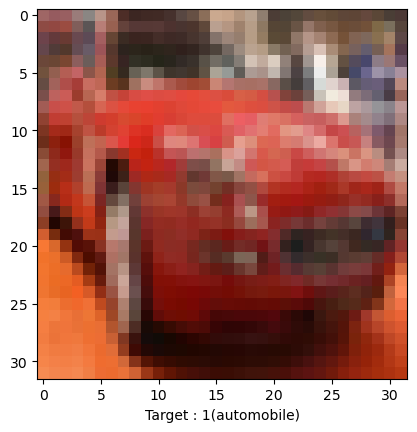

In [10]:
#(4) Display image
show_img(df=cifa_train, index=5)

#### 01.4. **데이터로더 변환**

In [11]:
cifa_train_loader = torch.utils.data.DataLoader(dataset=cifa_train, batch_size=BATCH_SIZE, shuffle=True)
cifa_test_loader = torch.utils.data.DataLoader(dataset=cifa_test, batch_size=BATCH_SIZE, shuffle=True)

<b></b>

## 03. **모델 구축 및 학습**

#### 03.1. **모델 정의**

In [12]:
#(1) Define `model`
model = MyClassificationModel(input_shape=(3, 32, 32)).to(dtype=torch.float32, device=device)

#(2) Display `model`
model

MyClassificationModel(
  (layers): ModuleDict(
    (conv_0): ModuleList(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (conv_1): ModuleList(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (conv_2): ModuleList(
      (0): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (conv_3): ModuleList(
      (0): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (fc_0): ModuleList(
      (0): Linear(in_features=32, out_features=32, bias=True)
      (1): ReLU()

In [13]:
#(3)
dummy = torch.randn(size=[BATCH_SIZE]+list(cifa_train[0][0].shape)).to(device=device)
torchinfo.summary(model=model, input_data=dummy)

Layer (type:depth-idx)                   Output Shape              Param #
MyClassificationModel                    [32, 10]                  --
├─ModuleDict: 1-1                        --                        --
│    └─ModuleList: 2-1                   --                        --
│    │    └─Conv2d: 3-1                  [32, 16, 32, 32]          448
│    │    └─ReLU: 3-2                    [32, 16, 32, 32]          --
│    │    └─MaxPool2d: 3-3               [32, 16, 16, 16]          --
│    └─ModuleList: 2-2                   --                        --
│    │    └─Conv2d: 3-4                  [32, 32, 16, 16]          4,640
│    │    └─ReLU: 3-5                    [32, 32, 16, 16]          --
│    │    └─MaxPool2d: 3-6               [32, 32, 8, 8]            --
│    └─ModuleList: 2-3                   --                        --
│    │    └─Conv2d: 3-7                  [32, 16, 8, 8]            4,624
│    │    └─ReLU: 3-8                    [32, 16, 8, 8]            --
│    │  

In [14]:
#(4) Define loss function
criterion = torch.nn.CrossEntropyLoss()

#(5) Define optimizer(optimization method)
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-2, weight_decay=1e-7)

#(6) Define Scheduler
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=30, gamma=0.1)

#### 03.2. **학습 전 변수 정의**

In [15]:
batch_cnt = len(cifa_train_loader)
if USE_PRETRAIN_YN == 'Y' :
    checkpoint = torch.load(f=MODEL_PTH)
    model.load_state_dict(state_dict=checkpoint['model'])
    optimizer.load_state_dict(state_dict=checkpoint['optimizer'])
    epoch = checkpoint['epoch']
    loss_hist = checkpoint['loss_hist']
    best_loss = loss_hist[-1]
else :
    epoch = 0
    loss_hist = []
    best_loss = float('inf')
print(f">> Epoch={epoch}, Train Loss={best_loss}")

>> Epoch=96, Train Loss=1.339189835564875


#### 03.3. **모델 학습**

In [16]:
progress_bar = tqdm.trange(epoch, EPOCH_NUM)
for epoch in progress_bar : 
    running_loss = 0.0
    model.train()
    for inputs, targets in cifa_train_loader :
        inputs = inputs.to(device=device) 
        targets = targets.to(device=device)
        optimizer.zero_grad() 
        preds = model(x=inputs)
        loss = criterion(input=preds, target=targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    running_loss_avg = running_loss / batch_cnt
    loss_hist.append(running_loss_avg)
    if running_loss_avg < best_loss :
        best_loss = running_loss_avg
        torch.save(
            obj={
                'epoch'     : epoch,
                'loss_hist' : loss_hist,
                'model'     : model.state_dict(),
                'optimizer' : optimizer.state_dict()
            }, 
            f=MODEL_PTH
        )
    # scheduler.step()
    progress_bar.set_postfix(ordered_dict={'epoch':epoch+1, 'loss':running_loss}) 

100%|██████████| 4/4 [01:10<00:00, 17.66s/it, epoch=100, loss=2.09e+3]


<b></b>

## 04. **모델 평가**

#### 04.1. **최적 성능 모델 로드**

In [17]:
checkpoint = torch.load(f=MODEL_PTH)
model.load_state_dict(state_dict=checkpoint['model'])
print(f'>> Epoch : {checkpoint["epoch"]}, Loss : {checkpoint["loss_hist"][-1]}')

>> Epoch : 99, Loss : 1.3377135138212681


#### 04.2. **학습 손실(Traing Loss) 확인**

In [18]:
#(1) Check metrics
compute_metrics(model=model, loader=cifa_train_loader)

,metricName,value
0,accuracy,0.527100
1,precision,0.538129
2,recall,0.527100
3,f1,0.519921


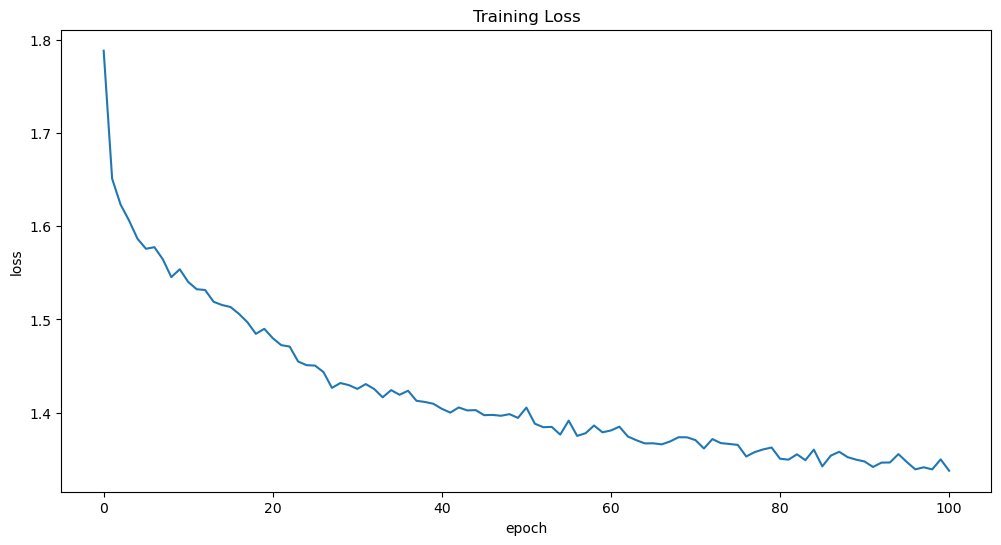

In [19]:
#(2) Plot traing loss
plt.figure(figsize=(12, 6))
plt.title(label='Training Loss')
plt.xlabel(xlabel='epoch')
plt.ylabel(ylabel='loss')
plt.plot(loss_hist)
plt.show()

#### 04.3. **성능 평가**

In [20]:
compute_metrics(model=model, loader=cifa_test_loader)

,metricName,value
0,accuracy,0.506300
1,precision,0.513014
2,recall,0.506300
3,f1,0.498088
